# **Import Library**

In [ ]:
import pandas as pd
import os
import zipfile
print(os.listdir("../input/dogs-vs-cats"))
import tensorflow as tf


#For splitting the dataset in test and val sets
from sklearn.model_selection import train_test_split

#For use of Keras Squence class that allows the load of batches
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

#For plot the images and graphs
#pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#magic function that work much like OS command-line calls
%matplotlib inline 
#with this backend, the output of plotting commands is displayed inline within frontends like Jupyter notebooks, directly below the code cell that produced it
import seaborn as sns
import random

#For metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

#For tensorflow dataset
import tensorflow_datasets as tfds

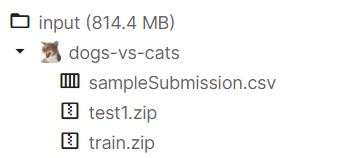

# Prepare Training Data

# With TFDS

In [ ]:
#TFDS - download the data and save it as tfrecord files
(tfds_train, tfds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train', 'train'],
    shuffle_files=True, #shuffles files during training
    as_supervised=True, #memorizes files as tuple rather than dict (default)
    with_info=True,
)

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

tfds_train = tfds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tfds_train = tfds_train.cache()
tfds_train = tfds_train.shuffle(ds_info.splits['train'].num_examples)
tfds_train = tfds_train.batch(128)
tfds_train = tfds_train.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
tfds_test = tfds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tfds_test = tfds_test.batch(128)
tfds_test = tfds_test.cache()
tfds_test = tfds_test.prefetch(tf.data.experimental.AUTOTUNE)

# With Keras Sequence

In [ ]:
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")

    
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")
    
train_path = "/kaggle/working/train"
train_filenames = os.listdir(train_path)
print(train_filenames[:5])


train_labels = []
for filename in train_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        train_labels.append(1)
    else:
        train_labels.append(0)


In [ ]:
train_df = pd.DataFrame({
    'filename': [train_path+'/'+filename for filename in train_filenames],
    'category': train_labels
})

type(train_df)


In [ ]:
train_df.head()

In [ ]:
train_df.tail()

In [ ]:
#Reduce the df for do some tests
train_df = train_df[0:12000]
train_df.shape

In [ ]:
train_df['category'].value_counts().plot.bar()

As we can see the distributions are balanced.

# See sample image

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    sample = imread(train_df['filename'][i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(sample)
plt.show()

In [ ]:
train_df.info()

In [ ]:
# Splitting in train set e validation set
train_df, valid_df = train_test_split(train_df, test_size=0.2)

In [ ]:
import tensorflow 
from tensorflow.keras import utils
from keras.utils import Sequence

#Use of Keras Sequence for extraction of mini-batches from dataset
class DFTOBATCHSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

# This method __getitem__ returns a batch in numpy array format
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (128, 128))
               for file_name in batch_x]), np.array(batch_y)

    
    
#Use of Keras Sequence for extraction labels of mini-batches from dataset
class PREDICTSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

# This method __getitem__ returns a batch in numpy array format without labels
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (128, 128))
               for file_name in batch_x])

In [ ]:
train_x = train_df.filename
train_y = train_df.category


print(train_y.shape)
train_y = np.asarray(train_y).astype('float32').reshape((-1,1)) 
print(train_y.shape)

val_x = valid_df.filename
val_y = valid_df.category


print(val_y.shape)
val_y = np.asarray(val_y).astype('float32').reshape((-1,1)) 
print(val_y.shape)

batch_size = 15

ds_train = DFTOBATCHSequence(train_x, train_y, batch_size)
ds_val = DFTOBATCHSequence(val_x, val_y, batch_size)

ds_train_ = PREDICTSequence(train_x, train_y, batch_size)

In [ ]:
ds_train.__getitem__(0)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True, 
)


model = Sequential()

model.add(Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # 1 or 2? because we have cat and dog classes

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

model.summary()

In [ ]:
# Method fit is called for 500 epochs on the training dataset and use the callbacks for stop when there is no improvement of val_loss
hisotry = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=30,
                    callbacks=[early_stopping], # callbacks are put in a list
                    )

In [ ]:
#Evaluation of the model performance
history_frame = pd.DataFrame(hisotry.history)
history_frame.head()

In [ ]:
sns.lineplot(data=history_frame.loc[:, ['loss', 'val_loss']])
plt.title("Loss Function on training set and validation set")
plt.xlabel("Epochs")

#history_frame.loc[:, ['loss', 'val_loss']].plot()
#history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
sns.lineplot(data=history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']])
plt.title("Accuracy on training set and validation set")
plt.xlabel("Epochs")

In [ ]:
#Predictions by fitted model
y_predict = model.predict(ds_train_)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(train_y, y_predict.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [ ]:
#Precision and Recall
precision, recall, thresholds = precision_recall_curve(train_y, y_predict)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()